In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from etc import PlanExposure

This notebook is an introduction to the python version of the exposure time calculator (ETC) for the Cryoscope Pathfinder mission and eventual full scale 1m Crysocope. If you'd prefer not work in python, an Excel version of the ETC is also provided on the main github page which provides rough estimates of SNR as a function of integration time for given magnitudes. The python version presented here is able to replicate those results and provide more involved treatments.  

The ETC will be continuously updated and refined throughout the project. 

In [2]:
# Function to show results in the tutorial.
def show_snr(plan,snr_results):
    # Presenting some outputs in a table
    print('Frame time: {} s'.format(plan.frame_time))
    print('Coadds: {}'.format(n))
    print('Total integration time: {:.1f} min'.format(plan.frame_time*n/60))
    print('Sky Rate: {:.1f} e/s/pix'.format(plan.calc_sky_rate()))

    df = pd.DataFrame({'AB_Magnitude': magrange,
                       '~VegMag': magrange-1.85, #This conversion to Vega Mag is not exact, the correction is for Ks not Kdark
                       'Src count rate (e/s)': snr_results['source_rate'], 
                       'SNR': snr_results['snr_total']})

    df['Src count rate (e/s)'] = df['Src count rate (e/s)'].round(1)
    df['SNR'] = df['SNR'].round(1)
    
    return df

Cryoscope's exposure time calculator is accessed via a python class PlanExposure. The code is contained in the etc.py file. This allows you to calculate the SNR for a defined exposure of a point source or to determine the minimum integration times needed to reach a desired SNR for certain K-dark AB magnitudes.

The simplest way of using the code is to initialize an object using the parameters specified in the parameter files provided for the prototype (Cryoscope Pathfinder) or the full scale system (1m Cryoscope). 

In [3]:
# Specify parameters in an input parameter file
filename = "prototype_params.txt" #This file is relevant for the Cryoscope Pathfinder mission

simple_plan = PlanExposure(param_file=filename,integrate=False)


To just use estimated values for some parameters including sky brightness and QE, set ``integrate`` to False. This will generate results equivalent to the Excel spreadsheet. Otherwise, by default ``integrate=True``. 

The main functions within the class you will call are ``calc_snr`` and ``calc_time`` 

To see how SNR depends on a range of magnitudes for a given exposure, use ``calc_snr``.
Set the desired number of coadds. Total integration time = coadds $\times$ frame time. The frame time is defined in the parameter file. By default it is 2 seconds.

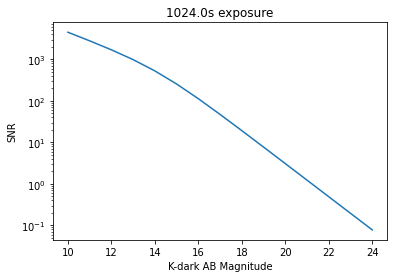

In [4]:
magrange = np.arange(10,25) #The ETC assumes AB magnitudes in K-dark are provided
n = 512 # Number of coadds

simple_info = simple_plan.calc_snr(ab_mag=magrange,coadds=n,plot=True)

The output of the ``calc_snr`` is a dictionary containing 
* **source_rate**: the source rate in electrons/sec for each magnitude provided
* **sky_rate**: the sky background rate in electrons/sec
* **tse_rate**: the thermal self emission rate in electrons/sec. This is from blackbody emission from the window that must be kept at ambient to avoid frosting up. It is set to zero for simplest estimates since sky background and detector noise dominate. For now this is only calculated for the Pathfinder.
* **detector_counts**: total number of electrons contributed by read noise and detector dark current. 
* **snr_frame**: the SNR for a single frame for each source. The frame time is 2 second by default in the parameter files.
* **snr_total**: the total integrated SNR after coadding for each source

For now, because Cryoscope is diffraction limited, the PSF will be undersampled and the number of pixels in the aperture of interest is 1. So each value is also per pixel. 

In [5]:
simple_info

{'source_rate': array([2.04386082e+04, 8.13675650e+03, 3.23930111e+03, 1.28958900e+03,
        5.13394627e+02, 2.04386082e+02, 8.13675650e+01, 3.23930111e+01,
        1.28958900e+01, 5.13394627e+00, 2.04386082e+00, 8.13675650e-01,
        3.23930111e-01, 1.28958900e-01, 5.13394627e-02]),
 'sky_rate': 337.8187902140413,
 'tse_rate': 0,
 'detector_counts': 225.2,
 'snr_frame': array([1.99989508e+02, 1.24176997e+02, 7.54170635e+01, 4.37210639e+01,
        2.33867479e+01, 1.12956276e+01, 4.98996756e+00, 2.08486231e+00,
        8.47282598e-01, 3.40170766e-01, 1.35886073e-01, 5.41709121e-02,
        2.15775413e-02, 8.59203238e-03, 3.42084438e-03]),
 'snr_total': array([4.52524599e+03, 2.80980469e+03, 1.70649334e+03, 9.89294744e+02,
        5.29181696e+02, 2.55590876e+02, 1.12910077e+02, 4.71750489e+01,
        1.91718167e+01, 7.69718576e+00, 3.07475085e+00, 1.22574782e+00,
        4.88244025e-01, 1.94415500e-01, 7.74048723e-02])}

In [6]:
show_snr(simple_plan,simple_info) # Just a way to show some of the results from the calculation.

Frame time: 2.0 s
Coadds: 512
Total integration time: 17.1 min
Sky Rate: 337.8 e/s/pix


,AB_Magnitude,~VegMag,Src count rate (e/s),SNR
0,10,8.15,20438.6,4525.2
1,11,9.15,8136.8,2809.8
2,12,10.15,3239.3,1706.5
3,13,11.15,1289.6,989.3
4,14,12.15,513.4,529.2
5,15,13.15,204.4,255.6
6,16,14.15,81.4,112.9
7,17,15.15,32.4,47.2
8,18,16.15,12.9,19.2
9,19,17.15,5.1,7.7


Otherwise, for more involved estimates, set ``integrate`` to True. This uses the data files to integrate over conservative estimates for the near-infrared sky transmission and sky brightness spectra (from Ashley et al, these are from the South Pole and thus the conservative bounds to Dome C expectations until we get on-sky), the H2RG QE curve, and the latest Asahi K-dark filter transmission curve. Make sure the paths to each file are correctly set in the parameter files.

This mode also includes noise from the thermal self emission from the first corrector lens (the window).   

In [7]:
plan = PlanExposure(param_file=filename,integrate=True)
obs_info = plan.calc_snr(ab_mag=magrange,coadds=n)

In [8]:
# Showing results after integrating over spectral data files
# While the sky background is lower from the average estimates, the total SNR is 
# lower because of lower source count rates, a consequence of the transmission 
show_snr(plan,obs_info)

Frame time: 2.0 s
Coadds: 512
Total integration time: 17.1 min
Sky Rate: 195.1 e/s/pix


,AB_Magnitude,~VegMag,Src count rate (e/s),SNR
0,10,8.15,13648.0,3696.5
1,11,9.15,5433.4,2294.0
2,12,10.15,2163.1,1391.6
3,13,11.15,861.1,804.8
4,14,12.15,342.8,429.0
5,15,13.15,136.5,206.4
6,16,14.15,54.3,90.9
7,17,15.15,21.6,37.9
8,18,16.15,8.6,15.4
9,19,17.15,3.4,6.2


Text(0.5, 0, 'K-dark AB Magnitude')

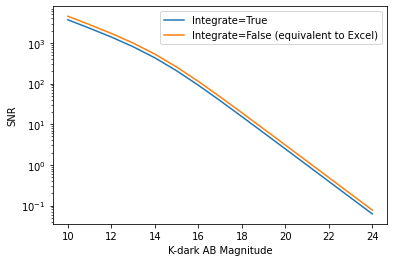

In [9]:
# Comparing SNR predicted via the two different methods of integrating over spectral data or using the Excel sheet
plt.plot(magrange,obs_info['snr_total'],label='Integrate=True')
plt.plot(magrange,simple_info['snr_total'],label='Integrate=False (equivalent to Excel)')
plt.legend()
plt.yscale('log')
plt.ylabel('SNR')
plt.xlabel('K-dark AB Magnitude')

Integrating over profiles provides a slightly more conservative SNR estimates for observations. This is primarily driven by the QE curve on hand. To see this, you can access relevant attributes of ``plan``. The list of all attributes can be found in etc.py

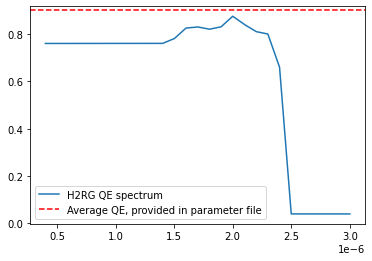

In [10]:
plt.plot(plan.wavgrid, plan.qe_lambda, label='H2RG QE spectrum')
plt.axhline(plan.avg_qe, color='red', ls='--',label='Average QE, provided in parameter file')
plt.legend()

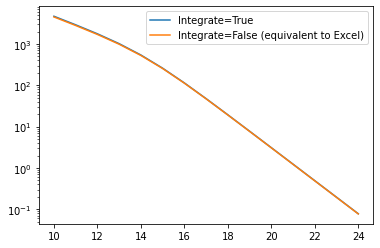

In [11]:
# Redefining QE at each wavelength to be the same as our simple estimate from before
plan_newqe = PlanExposure(param_file=filename,integrate=True)
plan_newqe.qe_lambda = plan_newqe.avg_qe

# Recalculating SNR
obs_info_newqe = plan_newqe.calc_snr(ab_mag=magrange,coadds=n)

#Plotting
plt.plot(magrange,obs_info_newqe['snr_total'],label='Integrate=True')
plt.plot(magrange,simple_info['snr_total'],label='Integrate=False (equivalent to Excel)')
plt.legend()
plt.yscale('log')

Feel free to make copies of the parameter files and change values as you see fit

For determining minimum integration times needed to reach a given SNR for a range of magnitudes, use ``calc_times``

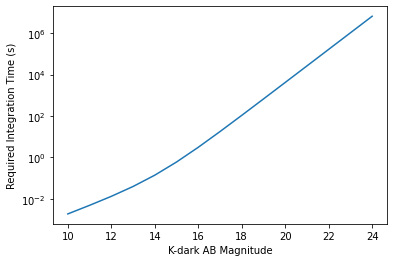

In [12]:
#Integration times needed to reach SNR=5 for the range of mags defined before.
times = plan.calc_time(magrange,snr_desired=5,plot=True)  #Results from integrating over spectral data files

In [13]:
#You can also do this for single sources too: 
single_mag = 19.2
time_sec = plan.calc_time(single_mag,snr_desired=5)

print('{} mag source: {:.1f} min integration'.format(single_mag,time_sec/60))

19.2 mag source: 16.1 min integration


For the full scale 1m Cryoscope: 

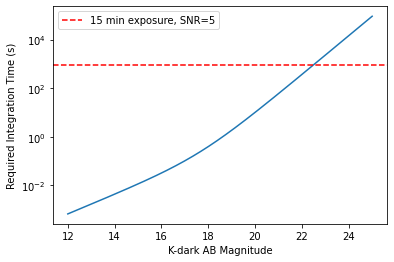

In [14]:
plan_1m = PlanExposure(param_file='fullscale_params.txt',integrate=True)
magrange_1m = np.linspace(12,25,10000)
times_1m = plan_1m.calc_time(magrange_1m,snr_desired=5,plot=True)
plt.axhline(15*60, label='15 min exposure, SNR=5',ls='--',color='r')
plt.legend()
plt.show()

In [20]:
print('15 min integration')
print('='*20)
print('Pathfinder, 5 sigma limiting depth: {:.1f}'.format(np.interp(20, times, magrange)))
print('Full scale, 5 sigma limiting depth: {:.1f}'.format(np.interp(900, times_1m, magrange_1m)))

print('\n1 hr integration')
print('='*20)
print('Pathfinder, 5 sigma limiting depth: {:.1f}'.format(np.interp(3600, times, magrange)))
print('Full scale, 5 sigma limiting depth: {:.1f}'.format(np.interp(3600, times_1m, magrange_1m)))

15 min integration
Pathfinder, 5 sigma limiting depth: 19.1
Full scale, 5 sigma limiting depth: 22.5

1 hr integration
Pathfinder, 5 sigma limiting depth: 19.8
Full scale, 5 sigma limiting depth: 23.2


If you'd like to play with the parameters with a script of your own, or would prefer not to use the parameter files, you can also specify parameters directly and combine them into a large array. Make sure the ordering is consistent as presented here.  

In [16]:
#Telescope properties/detector characteristics
frame_time = 2 #[s]
avg_skyBrightness = 1.20E-04 #K-dark Dome C estimate, [Jy arcsec^-2] (relevant only if skyBrightness_file not defined)
focal_length = 0.525 #[m]
read_noise = 15 #[e]
dark_current = 0.1 #[e/s]
pixel_size = 1.80E-05 #[m]
beam_obstruction = 8.0E-3 #[m^2] (Area of detector housing + spider vanes in the FOV)
avg_qe = 0.9 #(relevant only if qeData not defined)
aperture_diameter = 0.26 #[m]

#Throughputs
avg_skyTransmission = 0.95 #(relevant only if skyTransmission_file not defined)
avg_filterTransmission = 0.98 #(relevant only if filterTransmission_file not defined )
transmission_loss = 0.005 #Transmission loss per surface
num_tlosses = 4 #Number of transmission losses
reflection_loss = 0.04 # Loss per reflection
num_rlosses = 1 #Number of reflections

#K-dark observing
central_wavelength = 2.38e-06 #[m]
passband = 2.26e-07 #[m] (relevant only if filterTransmission_file not defined)
ambientTemp = -80 #Window temperature [C]

#Relevant parameters for integrating over spectral profiles (rather than using an estimate for an average value)
skyBrightness_file = 'data_files/ashley_sky.csv' #Sky brightness spectrum
skyTransmission_file = 'data_files/ashley_skytrans.csv' #Sky transmission spectrum
qe_file = 'data_files/H2RG_qedata.csv' #QE spectrum
filterTransmission_file = 'data_files/kdarkfilter.csv' #Filter transmission spectrum
sio2Transmission_file = 'data_files/sio2_tran.csv' #SiO2 transmission spectrum for corrector lens TSE calculations

parameters = np.array([frame_time,avg_skyBrightness,focal_length,read_noise,
                       dark_current,pixel_size,beam_obstruction,avg_qe,aperture_diameter,avg_skyTransmission,
                       avg_filterTransmission,transmission_loss,num_tlosses,reflection_loss,num_rlosses,
                       central_wavelength,passband,ambientTemp,skyBrightness_file,skyTransmission_file,
                       qe_file,filterTransmission_file,sio2Transmission_file])

And then specify ``param_arr`` instead of ``param_file`` when initializing. Everything else is the same from here.

In [17]:
plan = PlanExposure(param_arr=parameters)